# マスクが正しいか確認

In [24]:
from datetime import datetime
import pytz
import os
import numpy as np
import torch
import timm
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from model2 import Net,run_check_net
from dataset import read_one_data, read_one_truth
from czii_helper import dotdict

In [25]:
#trainに使う画像を取得
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

#マスクの大きさ
mask_size= {
    "defolt" : 1,
    "apo-ferritin" : 1,
    'beta-amylase' : 1, 
    'beta-galactosidase' : 1, 
    'ribosome' : 1, 
    'thyroglobulin' : 1, 
    'virus-like-particle' : 1,
}
MOLECULES = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

In [26]:
import cc3d
from dataset import *

def probability_to_location(probability,cfg):
    _,D,H,W = probability.shape

    location={}
    for p in PARTICLE:
        p = dotdict(p)
        l = p.label

        cc, P = cc3d.connected_components(probability[l]>cfg.threshold[p.name], return_N=True)
        stats = cc3d.statistics(cc)
        zyx=stats['centroids'][1:]*10
        xyz = np.ascontiguousarray(zyx[:,::-1]) 
        location[p.name]=xyz
        '''
            j=1
            z,y,x = np.where(cc==j)
            z=z.mean()
            y=y.mean()
            x=x.mean()
            print([x,y,z])
        '''
    return location

def location_to_df(location):
    location_df = []
    for p in PARTICLE:
        p = dotdict(p)
        xyz = location[p.name]
        if len(xyz)>0:
            df = pd.DataFrame(data=xyz, columns=['x','y','z'])
            #df.loc[:,'particle_type']= p.name
            df.insert(loc=0, column='particle_type', value=p.name)
            location_df.append(df)
    location_df = pd.concat(location_df)
    return location_df

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    #'/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
       "../analyze/model.pth",
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    },
)

In [27]:
def generate_mask(dic,mask_size):
    mask = np.zeros((184, 630, 630), dtype=np.int64)
    ID =0
    for target in MOLECULES:
        ID += 1
        for i in range(len(dic[target])):
            radius = mask_size[target]
            y = dic[target][i][0]
            x = dic[target][i][1]
            z = dic[target][i][2]

            # スケーリングと整数変換
            x, y, z = x / 10, y / 10, z / 10
            # 球状にmaskを作成
            for dz in range(-radius, radius + 1):
                for dx in range(-radius, radius + 1):
                    for dy in range(-radius, radius + 1):
                        # 球の条件を満たすか確認
                        if dx**2 + dy**2 + dz**2 <= radius**2:
                            nx, ny, nz = x + dx, y + dy, z + dz
                            # マスクの範囲内でのみ更新
                            if 0 <= nx < mask.shape[1] and 0 <= ny < mask.shape[2] and 0 <= nz < mask.shape[0]:
                                nz , nx, ny = int(nz), int(nx), int(ny)
                                mask[nz, nx, ny] = ID
    return mask

In [28]:
import numpy as np
import torch

def convert_to_torch_size(arr):
    # Number of unique classes (0-6)
    num_classes = 7

    # Create a one-hot encoded tensor
    one_hot = np.eye(num_classes)[arr]  # Shape: (32, 640, 640, 7)

    # Move the class axis to the first position
    one_hot = np.moveaxis(one_hot, -1, 0)  # Shape: (7, 32, 640, 640)

    # Convert to torch tensor
    one_hot_tensor = torch.tensor(one_hot, dtype=torch.float32)
    
    return one_hot_tensor


In [29]:
valid_dir = '../input/czii-cryo-et-object-identification/train'
valid_id = ['TS_5_4', "TS_6_4","TS_6_6","TS_69_2","TS_73_6","TS_86_3"]
id = 'TS_99_9'
H , W = 630, 630

mask = read_one_truth(id, overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')
#mask = generate_mask(mask, mask_size)
mask = np.load(f'../input/mask/train_label_{id}.npy')
pad_mask = np.pad(mask, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)

convert_to_torch_size(pad_mask).numpy()
location = probability_to_location(convert_to_torch_size(pad_mask).numpy(),cfg)
df = location_to_df(location)
df.insert(loc=0, column='experiment', value=id)

df.to_csv('submission.csv', index=False)

# サブミットの再現

#　検証スコア

['TS_99_9']
 TS_99_9 ribosomeactosidase

 TS_99_9 virus-like-particle
         particle_type   P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  36  36   36     0   0   1.000000  1.000000  1.000000   
1         beta-amylase  21  21   21     0   0   1.000000  1.000000  1.000000   
2   beta-galactosidase  21  24   21     3   0   1.000000  0.875000  0.881481   
3             ribosome  62  65   59     6   3   0.951613  0.907692  0.910163   
4        thyroglobulin  48  49   47     2   1   0.979167  0.959184  0.960337   
5  virus-like-particle  13  13   13     0   0   1.000000  1.000000  1.000000   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.9419713398955686

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 46
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12
	 num predict : 0
	 num hit  : 0
	 num fp   :

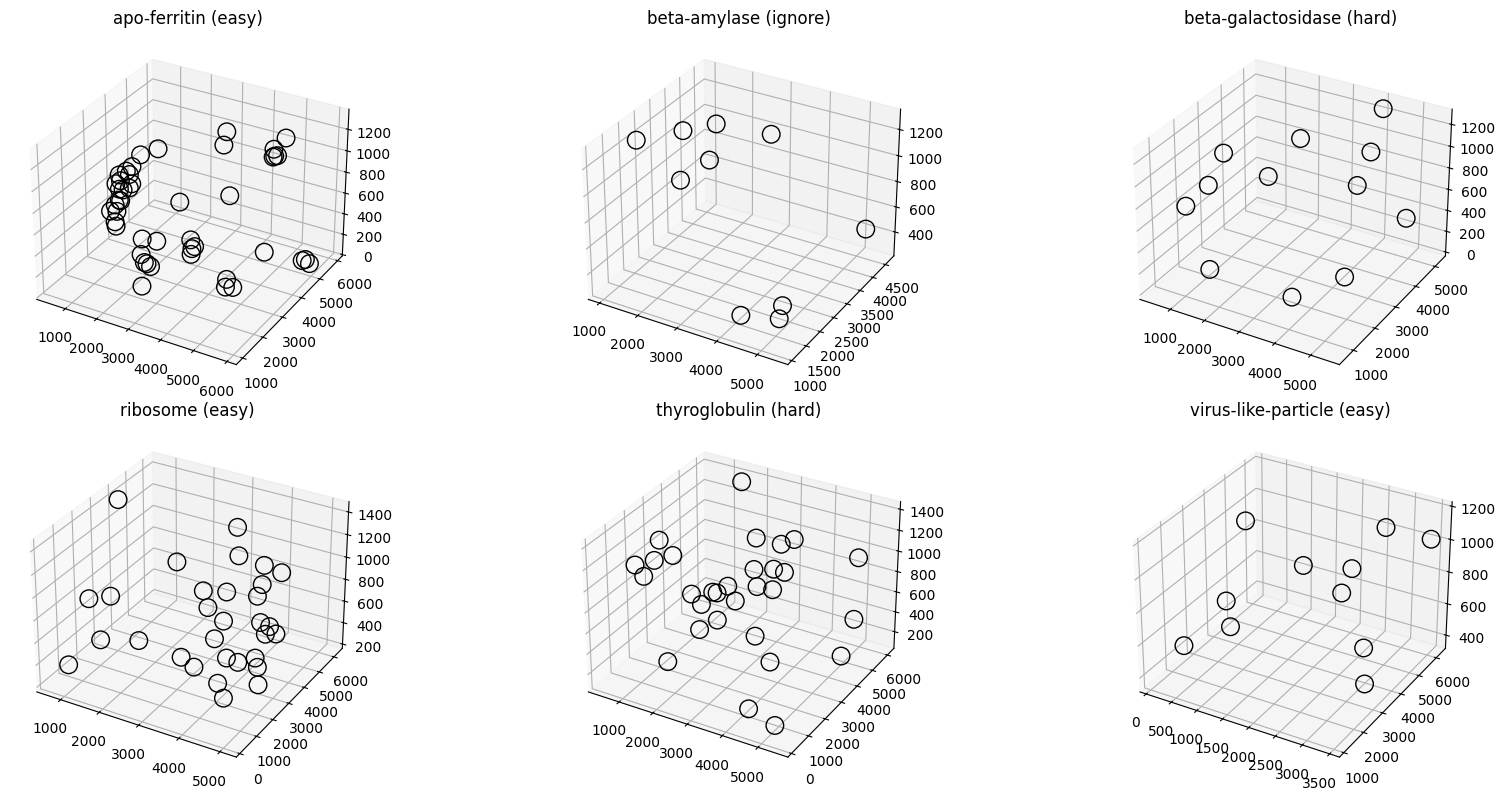

In [30]:
from scipy.optimize import linear_sum_assignment

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
MODE = 'local'
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0